<a href="https://colab.research.google.com/github/abeld19/mnist_cnn_project/blob/main/mnist_cnn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced MNIST Digit Classification Using Convolutional Neural Networks**

**Introduction**

The aim of this project is to build and optimise a Convolutional Neural Network (CNN) for classifying handwritten digits from the MNIST dataset. The primary objective is to achieve high accuracy while mitigating overfitting through various techniques such as Dropout, Batch Normalization, and Data Augmentation. Additionally, it explores advanced methods including hyperparameter tuning, model ensembling, and the use of depth-wise separable convolutions to further enhance model performance.

Import necessary libraries and modules for building and training the CNN model.



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, SeparableConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras_tuner as kt
from sklearn.metrics import accuracy_score
import datetime
import random


# **Set** Random Seeds for Reproducibility
Setting random seeds ensures that the results are reproducible.

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


# **Load and Preprocess Data for Multi-Input**
Load the MNIST dataset, normalise the images, create augmented images, and generate additional binary labels.

In [ ]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalise the images to [0, 1] range
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Reshape images to include channel dimension
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(train_images)

# Create augmented images as a second input using next() function
augmented_train_images = next(datagen.flow(train_images, train_labels, batch_size=len(train_images), shuffle=False))[0]
augmented_test_images = next(datagen.flow(test_images, test_labels, batch_size=len(test_images), shuffle=False))[0]

# Create binary labels for evenness
train_even_labels = (train_labels % 2 == 0).astype(int)
test_even_labels = (test_labels % 2 == 0).astype(int)

print(f"Training samples: {train_images.shape[0]}")
print(f"Test samples: {test_images.shape[0]}")

Training samples: 60000
Test samples: 10000


# **Exploratory Data Analysis (EDA)**

Displays sample images from the training dataset along with their labels.

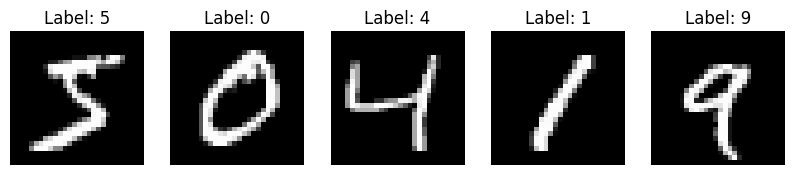

In [ ]:
# Display some sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(train_images[i].reshape(28,28), cmap='gray')
    axes[i].set_title(f"Label: {train_labels[i]}")
    axes[i].axis('off')
plt.show()


# **Building the Baseline Model**

 Defines and compiles a simple baseline CNN model.


In [ ]:
inputs = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

baseline_model = tf.keras.Model(inputs, outputs)
baseline_model.compile(optimizer="rmsprop",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])

baseline_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          54,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

# **Training the Baseline Model**

Trains the baseline model on the training data for 5 epochs with a validation split of 20%.

In [ ]:
history_baseline = baseline_model.fit(train_images, train_labels,
                                      epochs=5,
                                      validation_split=0.2)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8702 - loss: 0.4566 - val_accuracy: 0.9629 - val_loss: 0.1342
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9646 - loss: 0.1207 - val_accuracy: 0.9763 - val_loss: 0.0889
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9758 - loss: 0.0800 - val_accuracy: 0.9793 - val_loss: 0.0759
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9805 - loss: 0.0643 - val_accuracy: 0.9803 - val_loss: 0.0702
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9832 - loss: 0.0554 - val_accuracy: 0.9813 - val_loss: 0.0676


# **Evaluating the Baseline Model**

 Plots the training and validation accuracy and loss for the baseline model.

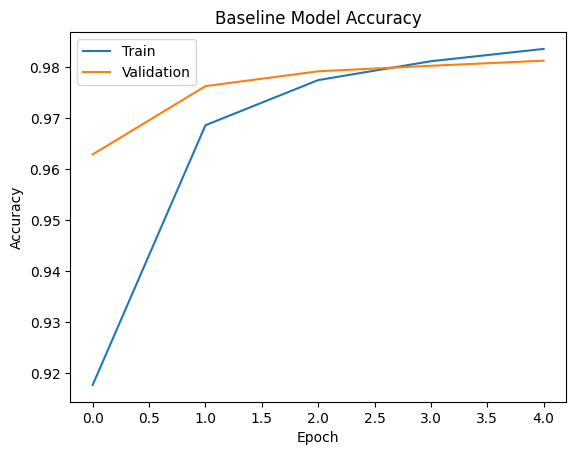

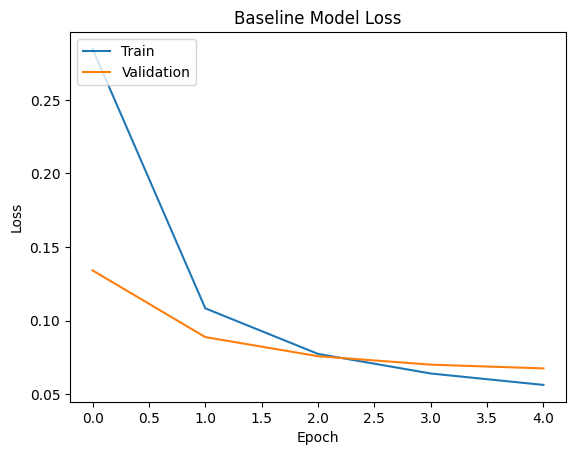

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Baseline Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Baseline Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Enhancing the Model with Dropout, Batch Normalization, and Additional Conv Layers**

Defines and compiles an enhanced CNN model with additional convolutional layers, Dropout, and Batch Normalization.

In [ ]:
def create_enhanced_model():
    inputs = tf.keras.Input(shape=(28, 28, 1))

    # First Convolutional Block
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Second Convolutional Block
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Fully Connected Layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

enhanced_model = create_enhanced_model()
enhanced_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,250 (477.54 KB)

 Non-trainable params: 320 (1.25 KB)

# **Training the Enhanced Model**

Trains the enhanced model on the training data for 5 epochs with a validation split of 20%.

In [ ]:
history_enhanced = enhanced_model.fit(train_images, train_labels,
                                      epochs=5,
                                      validation_split=0.2)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 70s 46ms/step - accuracy: 0.8680 - loss: 0.4158 - val_accuracy: 0.9797 - val_loss: 0.0637
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 68s 46ms/step - accuracy: 0.9684 - loss: 0.1035 - val_accuracy: 0.9829 - val_loss: 0.0553
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.9744 - loss: 0.0820 - val_accuracy: 0.9861 - val_loss: 0.0477
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.9779 - loss: 0.0718 - val_accuracy: 0.9867 - val_loss: 0.0427
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.9794 - loss: 0.0642 - val_accuracy: 0.9877 - val_loss: 0.0403


# **Evaluating the Enhanced Model**

 Plots the training and validation accuracy and loss for the enhanced model.

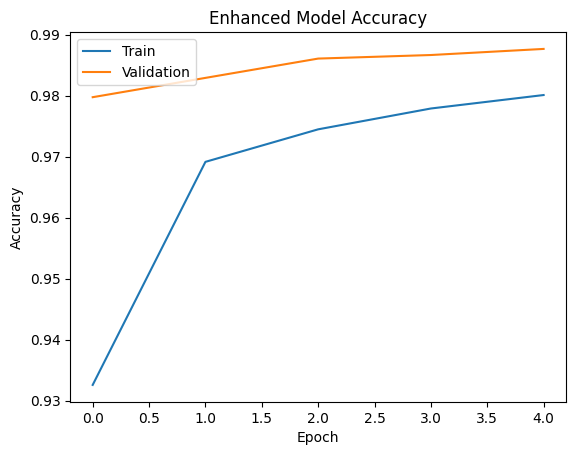

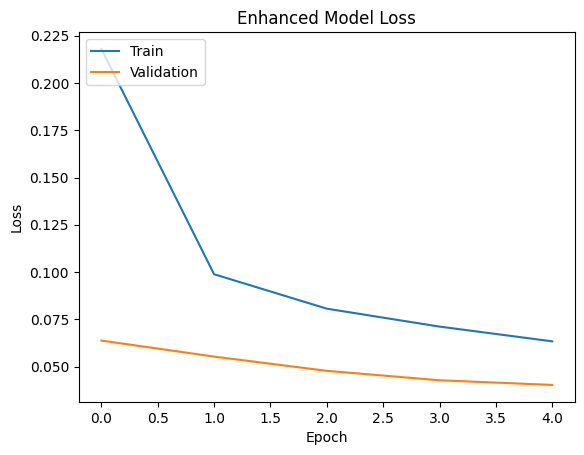

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_enhanced.history['accuracy'])
plt.plot(history_enhanced.history['val_accuracy'])
plt.title('Enhanced Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_enhanced.history['loss'])
plt.plot(history_enhanced.history['val_loss'])
plt.title('Enhanced Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Applying Data Augmentation**

Sets up data augmentation for the training images.

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(train_images)


# **Training the Model with Augmented Data**

Trains the enhanced model using augmented data for 5 epochs with a validation set.

In [ ]:
history_augmented = enhanced_model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=5,
    validation_data=(test_images, test_labels)
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 101s 106ms/step - accuracy: 0.9219 - loss: 0.2669 - val_accuracy: 0.9884 - val_loss: 0.0366
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 99s 105ms/step - accuracy: 0.9553 - loss: 0.1464 - val_accuracy: 0.9901 - val_loss: 0.0308
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 141s 104ms/step - accuracy: 0.9611 - loss: 0.1228 - val_accuracy: 0.9883 - val_loss: 0.0359
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 105ms/step - accuracy: 0.9688 - loss: 0.1016 - val_accuracy: 0.9909 - val_loss: 0.0276
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 104ms/step - accuracy: 0.9666 - loss: 0.1055 - val_accuracy: 0.9916 - val_loss: 0.0256


# **Evaluating the Model Trained with Augmented Data**

 Plots the training and validation accuracy and loss for the model trained with augmented data.


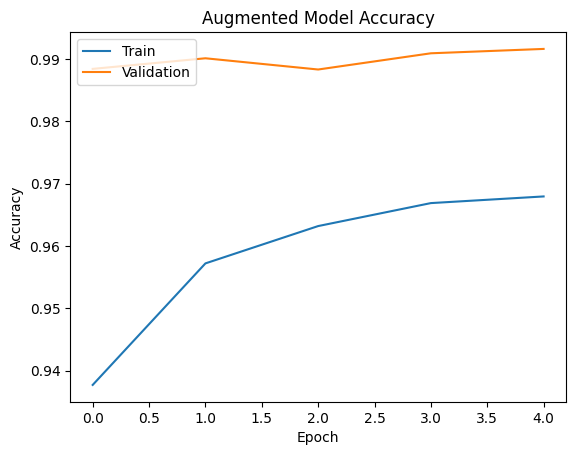

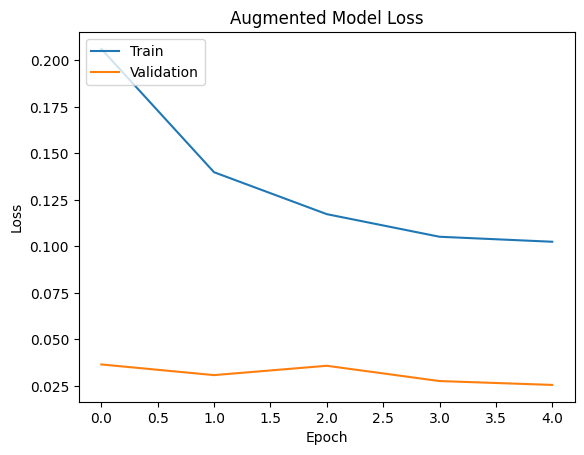

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_augmented.history['accuracy'])
plt.plot(history_augmented.history['val_accuracy'])
plt.title('Augmented Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_augmented.history['loss'])
plt.plot(history_augmented.history['val_loss'])
plt.title('Augmented Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# **Hyperparameter Tuning**

Performs hyperparameter tuning by training models with different learning rates and dropout rates, and prints the validation accuracy for each combination.

In [ ]:
def create_model(dropout_rate=0.5, learning_rate=0.001):
    inputs = tf.keras.Input(shape=(28, 28, 1))

    # First Convolutional Block
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Second Convolutional Block
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Fully Connected Layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Define hyperparameters
learning_rates = [0.001, 0.0005]
dropout_rates = [0.3, 0.5]

results = {}

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"\nTraining with learning_rate={lr} and dropout_rate={dr}")
        model = create_model(dropout_rate=dr, learning_rate=lr)
        history = model.fit(train_images, train_labels,
                            epochs=5,
                            validation_split=0.2,
                            verbose=1)
        val_accuracy = history.history['val_accuracy'][-1]
        results[f"lr={lr}_dr={dr}"] = val_accuracy
        print(f"Validation Accuracy: {val_accuracy:.4f}")

# Display the results
print("\nHyperparameter Tuning Results:")
for params, acc in results.items():
    print(f"{params}: Validation Accuracy = {acc:.4f}")



Training with learning_rate=0.001 and dropout_rate=0.3
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 52ms/step - accuracy: 0.9073 - loss: 0.3055 - val_accuracy: 0.9834 - val_loss: 0.0578
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9781 - loss: 0.0687 - val_accuracy: 0.9847 - val_loss: 0.0488
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.9819 - loss: 0.0555 - val_accuracy: 0.9898 - val_loss: 0.0336
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.9859 - loss: 0.0438 - val_accuracy: 0.9895 - val_loss: 0.0341
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - accuracy: 0.9869 - loss: 0.0431 - val_accuracy: 0.9900 - val_loss: 0.0311
Validation Accuracy: 0.9900

Training with learning_rate=0.001 and dropout_rate=0.5
Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - accuracy: 0.8583 - loss: 0.4517 - val_accuracy: 0.9809 - val_loss: 0.0630
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 77s 51ms/step - accuracy: 0.9670 

# **Define Callbacks**

Defines callbacks for early stopping, model checkpointing, learning rate reduction, and TensorBoard logging.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

# Create 'outputs' folder
if not os.path.exists('outputs'):
    os.makedirs('outputs')

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_digit_output_accuracy',
    patience=2,
    restore_best_weights=True,
    mode='max'
)

checkpoint = ModelCheckpoint(
    filepath='outputs/best_model.keras',
    monitor='val_digit_output_accuracy',
    save_best_only=True,
    mode='max'
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_digit_output_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='min',
    min_lr=1e-6
)

tensorboard_cb = TensorBoard(
    log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    histogram_freq=1
)

callbacks = [early_stop, checkpoint, lr_scheduler, tensorboard_cb]


# **Define the Multi-Input and Multi-Output Model with Depth-Wise Separable Convolutions**

Defines and compiles an advanced multi-input and multi-output CNN model with depth-wise separable convolutions.

In [ ]:
def create_advanced_model(dropout_rate=0.5, learning_rate=0.001, optimizer_choice='adam'):
    # Define two input layers
    input1 = Input(shape=(28, 28, 1), name='input_image')
    input2 = Input(shape=(28, 28, 1), name='input_augmented_image')

    # Separable Convolutional Block
    def sep_conv_block(x):
        x = SeparableConv2D(32, kernel_size=3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=2)(x)
        x = Dropout(dropout_rate)(x)
        return x

    # Process both inputs
    processed_input1 = sep_conv_block(input1)
    processed_input2 = sep_conv_block(input2)

    # Concatenate processed inputs
    concatenated = tf.keras.layers.concatenate([processed_input1, processed_input2])

    # Further Separable Convolutional Layers
    x = SeparableConv2D(64, kernel_size=3, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(dropout_rate)(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output layers
    output_digit = Dense(10, activation='softmax', name='digit_output')(x)
    output_even = Dense(1, activation='sigmoid', name='even_output')(x)

    # Define the model with two inputs and two outputs
    model = Model(inputs=[input1, input2], outputs=[output_digit, output_even])

    # Select optimizer
    if optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss={'digit_output': 'sparse_categorical_crossentropy',
                        'even_output': 'binary_crossentropy'},
                  metrics={'digit_output': 'accuracy',
                           'even_output': 'accuracy'})

    return model

# Instantiate the advanced model
advanced_model = create_advanced_model(dropout_rate=0.5, learning_rate=0.001, optimizer_choice='adam')
advanced_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_augmented_image     │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 26, 26, 32)     │             73 │ input_image[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_4        │ (None, 26, 26, 32)     │             73 │ input_augmented_image… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 26, 26, 32)     │            128 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 26, 26, 32)     │            128 │ separable_conv2d_4[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 13, 13, 32)     │              0 │ batch_normalization_4… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 13, 13, 32)     │              0 │ batch_normalization_5… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 13, 13, 32)     │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 13, 13, 32)     │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 13, 13, 64)     │              0 │ dropout_4[0][0],       │
│ (Concatenate)             │                        │                │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_5        │ (None, 11, 11, 64)     │          4,736 │ concatenate_1[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 11, 11, 64)     │            256 │ separable_conv2d_5[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 5, 5, 64)       │              0 │ batch_normalization_6… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 212,253 (829.11 KB)

 Trainable params: 211,741 (827.11 KB)

 Non-trainable params: 512 (2.00 KB)

# **Train the Advanced Model**

Trains the advanced model using both original and augmented images for 5 epochs with a validation split of 20% and defined callbacks.

In [ ]:
# Train the advanced model
history_advanced = advanced_model.fit(
    [train_images, augmented_train_images],
    {'digit_output': train_labels, 'even_output': train_even_labels},
    epochs=5,
    validation_split=0.2,
    callbacks=callbacks,
    batch_size=64
)



Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 106s 136ms/step - digit_output_accuracy: 0.6994 - digit_output_loss: 0.9730 - even_output_accuracy: 0.8417 - even_output_loss: 0.3724 - loss: 1.3455 - val_digit_output_accuracy: 0.9376 - val_digit_output_loss: 0.2133 - val_even_output_accuracy: 0.9470 - val_even_output_loss: 0.1428 - val_loss: 0.3569 - learning_rate: 0.0010
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step - digit_output_accuracy: 0.9124 - digit_output_loss: 0.2820 - even_output_accuracy: 0.9454 - even_output_loss: 0.1481 - loss: 0.4301 - val_digit_output_accuracy: 0.9603 - val_digit_output_loss: 0.1240 - val_even_output_accuracy: 0.9729 - val_even_output_loss: 0.0731 - val_loss: 0.1976 - learning_rate: 0.0010
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 138s 131ms/step - digit_output_accuracy: 0.9283 - digit_output_loss: 0.2320 - even_output_accuracy: 0.9562 - even_output_loss: 0.1189 - loss: 0.3508 - val_digit_output_accuracy: 0.9688 - val_digit_output_loss: 0.1052 - val_even_out

# **Hyperparameter Optimization with Keras Tuner**

In [ ]:
from keras_tuner import Objective

def build_model_tuner(hp):
    # Define two input layers
    input1 = Input(shape=(28, 28, 1), name='input_image')
    input2 = Input(shape=(28, 28, 1), name='input_augmented_image')

    # Hyperparameters to tune
    dropout_rate = hp.Float('dropout_rate', 0.3, 0.6, step=0.1)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])

    # Separable Convolutional Block
    def sep_conv_block(x):
        x = SeparableConv2D(32, kernel_size=3, activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=2)(x)
        x = Dropout(dropout_rate)(x)
        return x

    # Process both inputs
    processed_input1 = sep_conv_block(input1)
    processed_input2 = sep_conv_block(input2)

    # Concatenate processed inputs
    concatenated = tf.keras.layers.concatenate([processed_input1, processed_input2])

    # Further Separable Convolutional Layers
    x = SeparableConv2D(64, kernel_size=3, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(dropout_rate)(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Output layers
    output_digit = Dense(10, activation='softmax', name='digit_output')(x)
    output_even = Dense(1, activation='sigmoid', name='even_output')(x)

    # Define the model
    model = Model(inputs=[input1, input2], outputs=[output_digit, output_even])

    # Select optimizer
    if optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss={'digit_output': 'sparse_categorical_crossentropy',
                        'even_output': 'binary_crossentropy'},
                  metrics={'digit_output': 'accuracy',
                           'even_output': 'accuracy'})

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model_tuner,
    objective=Objective("val_digit_output_accuracy", direction="max"),
    max_trials=3,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='mnist_cnn'
)

# Display search space summary
tuner.search_space_summary()

# Define Early Stopping Callback for tuning
tuner_early_stop = EarlyStopping(
    monitor='val_digit_output_accuracy',
    patience=1,
    restore_best_weights=True,
    mode='max'
)

# Run the hyperparameter search
tuner.search(
    [train_images, augmented_train_images],
    {'digit_output': train_labels, 'even_output': train_even_labels},
    epochs=5,
    validation_split=0.2,
    callbacks=[tuner_early_stop],
    batch_size=64
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"Optimal Learning Rate: {best_hps.get('learning_rate')}")
print(f"Optimal Optimizer: {best_hps.get('optimizer')}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)
history_best = best_model.fit(
    [train_images, augmented_train_images],
    {'digit_output': train_labels, 'even_output': train_even_labels},
    epochs=5,
    validation_split=0.2,
    callbacks=callbacks,
    batch_size=64
)

# Save the best hyperparameter-tuned model
best_model.save('outputs/best_model_tuned.keras')


Trial 3 Complete [00h 11m 53s]
val_digit_output_accuracy: 0.9511666893959045

Best val_digit_output_accuracy So Far: 0.9777500033378601
Total elapsed time: 00h 42m 26s
Optimal Dropout Rate: 0.4
Optimal Learning Rate: 0.0008183184659748614
Optimal Optimizer: rmsprop
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 106s 138ms/step - digit_output_accuracy: 0.8087 - digit_output_loss: 0.6149 - even_output_accuracy: 0.8724 - even_output_loss: 0.2979 - loss: 0.9128 - val_digit_output_accuracy: 0.9525 - val_digit_output_loss: 0.1558 - val_even_output_accuracy: 0.9702 - val_even_output_loss: 0.0841 - val_loss: 0.2400 - learning_rate: 8.1832e-04
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 136s 129ms/step - digit_output_accuracy: 0.9471 - digit_output_loss: 0.1688 - even_output_accuracy: 0.9662 - even_output_loss: 0.0925 - loss: 0.2613 - val_digit_output_accuracy: 0.9722 - val_digit_output_loss: 0.0900 - val_even_output_accuracy: 0.9831 - val_even_output_loss: 0.0519 - val_loss: 0.1421 - learning_rate: 8.1832e

#  **Model Ensembling**
Train multiple models and ensemble their predictions, setting epochs=5 for each.

In [ ]:
# Define the number of models in the ensemble
num_ensemble_models = 3

# Function to create models for the ensemble
def create_ensemble_model(dropout_rate=0.5, learning_rate=0.001, optimizer_choice='adam'):
    model = create_advanced_model(dropout_rate=dropout_rate, learning_rate=learning_rate, optimizer_choice=optimizer_choice)
    return model

# Train multiple models and add them to the ensemble
ensemble_models = []
for i in range(num_ensemble_models):
    print(f"\nTraining ensemble model {i+1}")
    model = create_ensemble_model(dropout_rate=0.5, learning_rate=0.001, optimizer_choice='adam')
    history = model.fit(
        [train_images, augmented_train_images],
        {'digit_output': train_labels, 'even_output': train_even_labels},
        epochs=5,
        validation_split=0.2,
        callbacks=callbacks,
        batch_size=64,
        verbose=1
    )
    ensemble_models.append(model)

# Function to make ensemble predictions
def ensemble_predict(models, inputs):
    digit_preds = [model.predict(inputs)[0] for model in models]
    even_preds = [model.predict(inputs)[1] for model in models]

    avg_digit_preds = np.mean(digit_preds, axis=0)
    avg_even_preds = np.mean(even_preds, axis=0)

    final_digit_preds = np.argmax(avg_digit_preds, axis=1)
    final_even_preds = (avg_even_preds > 0.5).astype(int).flatten()

    return final_digit_preds, final_even_preds

# Make ensemble predictions
digit_predictions, even_predictions = ensemble_predict(ensemble_models, [test_images, augmented_test_images])

# Evaluate ensemble predictions
digit_accuracy = accuracy_score(test_labels, digit_predictions)
even_accuracy = accuracy_score(test_even_labels, even_predictions)

print(f"Ensemble Digit Accuracy: {digit_accuracy:.4f}")
print(f"Ensemble Even Accuracy: {even_accuracy:.4f}")

# Save ensemble models
for idx, model in enumerate(ensemble_models):
    model.save(f'outputs/ensemble_model_{idx+1}.keras')  # Using .keras extension

# Save ensemble predictions
df_ensemble = pd.DataFrame({
    'True Label': test_labels,
    'Predicted Digit': digit_predictions,
    'Predicted Even': even_predictions
})
df_ensemble.to_csv('outputs/ensemble_predictions.csv', index=False)



Training ensemble model 1
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - digit_output_accuracy: 0.6700 - digit_output_loss: 1.0679 - even_output_accuracy: 0.8159 - even_output_loss: 0.4172 - loss: 1.4851 - val_digit_output_accuracy: 0.9498 - val_digit_output_loss: 0.1708 - val_even_output_accuracy: 0.9573 - val_even_output_loss: 0.1186 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 139s 130ms/step - digit_output_accuracy: 0.9114 - digit_output_loss: 0.2894 - even_output_accuracy: 0.9398 - even_output_loss: 0.1597 - loss: 0.4491 - val_digit_output_accuracy: 0.9637 - val_digit_output_loss: 0.1120 - val_even_output_accuracy: 0.9768 - val_even_output_loss: 0.0647 - val_loss: 0.1771 - learning_rate: 0.0010

Training ensemble model 2
Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - digit_output_accuracy: 0.7139 - digit_output_loss: 0.9300 - even_output_accuracy: 0.8286 - even_output_loss: 0.3888 - loss: 1.3188 - val_digit_output_accuracy:

# **Save Plots and Final Outputs**
Generate and save plots to visualize your model's performance.

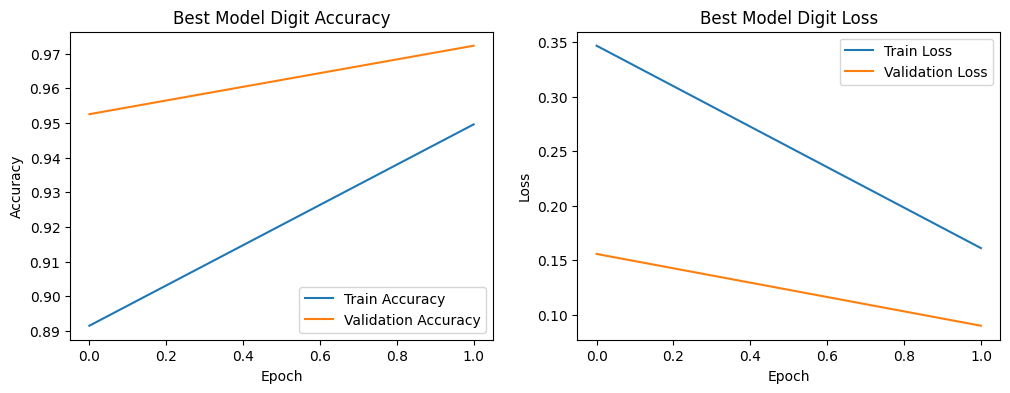

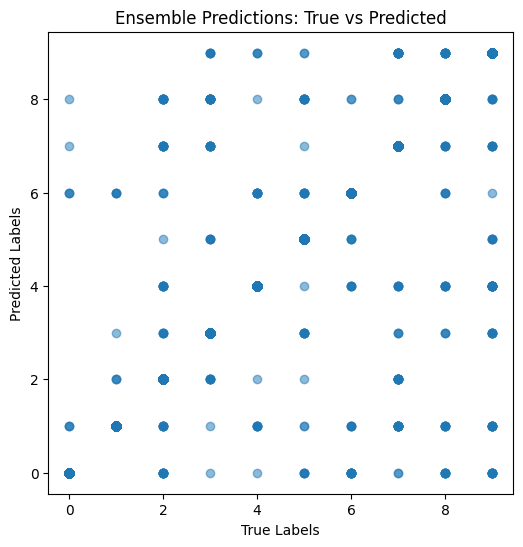

In [ ]:
def save_final_plots(history, model_type):
    plt.figure(figsize=(12, 4))

    # Digit Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['digit_output_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_digit_output_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_type} Model Digit Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.savefig(f'outputs/{model_type.lower()}_digit_accuracy_plot.png')

    # Digit Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['digit_output_loss'], label='Train Loss')
    plt.plot(history.history['val_digit_output_loss'], label='Validation Loss')
    plt.title(f'{model_type} Model Digit Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.savefig(f'outputs/{model_type.lower()}_digit_loss_plot.png')

    plt.show()

# Save plots for the best hyperparameter-tuned model
save_final_plots(history_best, 'Best')

# Save ensemble predictions plot
plt.figure(figsize=(6,6))
plt.scatter(test_labels, digit_predictions, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Ensemble Predictions: True vs Predicted')
plt.savefig('outputs/ensemble_true_vs_predicted.png')
plt.show()


# **Conclusion**

The project successfully enhanced a Convolutional Neural Network (CNN) for MNIST digit classification through the implementation of several advanced techniques. Starting from a simple baseline model, additional convolutional layers, Dropout, and Batch Normalisation were incorporated to improve accuracy and reduce overfitting. Data augmentation further boosted the model's generalisation capabilities. Hyperparameter tuning with Keras Tuner fine-tuned the model's performance. A multi-input, multi-output approach using depth-wise separable convolutions efficiently handled both digit and even/odd classification tasks. Ensembling multiple models led to further accuracy gains. The use of callbacks like EarlyStopping and ModelCheckpoint ensured optimal training processes. Visualising training and validation metrics provided insights that guided enhancements. Ultimately, these efforts culminated in a robust and high-performing CNN, demonstrating the value of these advanced methods in achieving superior classification results.

## References

1. **TensorFlow**

   Abadi, M., Barham, P., Chen, J., Chen, Z., Davis, A., Dean, J., ... & Zheng, X. (2016). *TensorFlow: A system for large-scale machine learning*. In *12th USENIX Symposium on Operating Systems Design and Implementation (OSDI 16)* (pp. 265-283).

2. **Keras**

   Chollet, F. (2015). *Keras*. GitHub. [https://github.com/keras-team/keras](https://github.com/keras-team/keras)

3. **Keras Tuner**

   Raschka, S., & Mirjalili, V. (2020). *Keras Tuner: A Library for Hyperparameter Tuning in Keras*. GitHub. [https://github.com/keras-team/keras-tuner](https://github.com/keras-team/keras-tuner)

4. **MNIST Dataset**

   LeCun, Y., Cortes, C., & Burges, C. J. (2010). *MNIST handwritten digit database*. AT&T Labs [Online]. Available: [http://yann.lecun.com/exdb/mnist/](http://yann.lecun.com/exdb/mnist/)

5. **Depthwise Separable Convolutions**

   Chollet, F. (2017). *Xception: Deep learning with depthwise separable convolutions*. In *Proceedings of the IEEE conference on computer vision and pattern recognition* (pp. 1251-1258).

6. **Separable Convolutions (MobileNets)**

   Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). *MobileNets: Efficient convolutional neural networks for mobile vision applications*. arXiv preprint arXiv:1704.04861.

7. **Batch Normalization**

   Ioffe, S., & Szegedy, C. (2015). *Batch normalization: Accelerating deep network training by reducing internal covariate shift*. In *International Conference on Machine Learning* (pp. 448-456). PMLR.

8. **Dropout**

   Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). *Dropout: A simple way to prevent neural networks from overfitting*. *Journal of Machine Learning Research*, *15*(1), 1929-1958.

9. **Early Stopping**

   Prechelt, L. (1998). *Early stopping - but when?*. In *Neural Networks: Tricks of the trade* (pp. 55-69). Springer, Berlin, Heidelberg.

10. **TensorBoard**

    TensorFlow Development Team. (2023). *TensorBoard: Visualizing Learning*. TensorFlow. [https://www.tensorflow.org/tensorboard](https://www.tensorflow.org/tensorboard)

11. **Adam Optimizer**

    Kingma, D. P., & Ba, J. (2015). *Adam: A method for stochastic optimization*. arXiv preprint arXiv:1412.6980.

12. **RMSprop Optimizer**

    Hinton, G. (2012). *Neural networks for machine learning*. Coursera Lectures. [http://www.cs.toronto.edu/~hinton/absps/momentum.pdf](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf)

13. **Stochastic Gradient Descent (SGD)**

    Robbins, H., & Monro, S. (1951). *A stochastic approximation method*. *The Annals of Mathematical Statistics*, *22*(3), 400-407.


